# Test Battery for Clique Detection

I'm here:
1. Extact loops from the pair
1. Fix the ```1AB 2AB 3AB --> 123 AB``` problem

In [62]:
# Parameters
# METHOD_ID="2020-01-20 partial pairs"
# METHOD_ID="2020-01-24 all pairs"
METHOD_ID="2020-01-25 untangled"

In [2]:
%load_ext autoreload
%autoreload 2
%config Application.log_level="INFO"

import logging
import sys
import networkx as nx
# import scipy
import matplotlib.pyplot as plt

# logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
# logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG, stream=sys.stdout)

In [56]:
def evaluate_against (T, expected_paths):
    G, paths = False, False
    
    if   METHOD_ID=="2020-01-24 all pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-24 all pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-20 partial pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-20 partial pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-25 untangled":
        
        succ_G = successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-25 untangled")  )

        # Step 1: Detect loops
        paths = infer_paths( split_in_freqGraph(  succ_G  ) )
        
        G_aux = created_auxiliary_graph( paths )
        G = minimally_connected(G_aux)
        
#         G_freq = split_in_freqGraph(G)
#         for f, g1 in G_freq.items():
#             graph(g1, with_weigths=True)
            
        graph(G)

#         paths = { 1:[] }
# #         for f, G1 in G_freq.items():
# #             paths[f] = nx.all_shortest_paths(G, "_START_", "_END_")
            
#         for path in nx.all_simple_paths(G, "_START_", "_END_"):
#             path.remove("_START_")
#             path.remove("_END_")
#             paths[1].append( path )
        

    else:
        raise ValueError("Not valid METHOD_ID")
             
            
    if paths:
        
        G = nx.DiGraph()
        for f, path in paths.items():
            for a, b in [ (a,b) for t in path for a,b in zip( t[:-1], t[1:] )  ]:
                G.add_edge( a, b, weight=f)
        graph(G, with_weigths=True )
        
        good = []
        bad = []
        expected = [ list(a) for a in expected_paths ]
        for f, paths in paths.items():
            for p in paths:
    #             print(paths)
                if p in expected:
                    good.append( "%d: %s" % (f, "".join(p)) )
                else:
                    bad.append( "%d: %s" % (f, "".join(p)) )

        if len(expected_paths) != len(good):
            print(), print()
            print("WARNING HERE! OJO AQUI!")
            print(), print()
        print("These %s paths were correctly detected (%s undetected):" % (len(good), len(expected_paths)-len(good)))
        print(good)
        print()

        print("These %s paths are spurious:" % len(bad))
        print (bad)
        return good, bad
    else:
        return [], []

In [4]:
def created_auxiliary_graph( weighted_paths ):
    
    def append_path(G, path, weight):
        edges = []
        previous = path[0]
        for node in path[1:]:
            edges.append( (previous, node, {"weight": round(weight, 2)} ) )
            previous = node
        G.add_edges_from(edges)

    G = nx.DiGraph()
    for w in sorted(weighted_paths, reverse=True):
        for path_w in weighted_paths[w]:
            append_path( G, path_w, w )            
    return G

In [5]:
#2020-01-25
# If paths (u,z,v) and (u,v) exists, leave just (u,z,v)
def minimally_connected(G):
    G_minimal = G.copy()
    
    for u, v in G.edges():

        # u has already v, then I will work if I have more than one neighbor
        if len(G[u]) > 1:
            remove_edge = False
            # look if I have a longest u,z,v path
            for z, attr in G[u].items():
                if z != v and z != u:
                    if nx.has_path(G_minimal, z, v):
                        remove_edge = True
            if remove_edge:
                G_minimal.remove_edge( u, v )    
    return G_minimal

In [6]:
def graph(G, color="#cccccc", with_weigths=True):
    pos = nx.circular_layout(G)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.subplot(111)

    nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.03' )
    if with_weigths:
        weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights)
    plt.show()

In [59]:
def get_successor_by_freq( traces, METHOD_ID="2020-01-24 all pairs" ):
    """
    Get successor pairs in every T in traces, and combine them by frequency of appearance.
    
    >>> T = [ list("ABC"), list("ABCABC") ]
    >>> get_successor_pairs_by_freq(T)
    {('A', 'B'): 3, ('A', 'C'): 3, ('B', 'C'): 3, ('B', 'A'): 1, ('C', 'A'): 1, ('C', 'B'): 1}
    """
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.info("Using METHOD_ID % s" % METHOD_ID)
    
    pairs_with_freq = {}
    L = float(len(traces))

    for trace in traces:
        for pair in get_successor_pairs(trace, METHOD_ID=METHOD_ID):
            if pair in pairs_with_freq.keys():
                pairs_with_freq[pair] = pairs_with_freq[pair] + 1.0/L
            else:
                pairs_with_freq[pair] = 1.0/L
            
    By_freq = {}
    for (u, v), freq in pairs_with_freq.items():
        f = round(freq,3)
        if f in By_freq.keys():
            By_freq[f].append( (u,v) )
        else:
            By_freq[f] =[ (u,v) ]
    logger.debug("Freq  pairs using method=%s : %s" % (METHOD_ID, By_freq) )
    return By_freq

In [54]:
def successorsGraph(successor_by_freq):
    G=nx.DiGraph()
    for f, pairs in successor_by_freq.items():
        for u, v in pairs:
            G.add_edge(u, v, weight=f)
            
    return G

In [9]:
# Sort the cliques and apply the rules:
# 1) The nodes of a single path in their equivalent pair has in_degree=0,1,2,...
# 2) A path is composed for at least 2 nodes

def infer_paths(G_freq, min_clique_size=2):
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.debug("Received a dict G with f=%s" % G_freq.keys())

    paths_f = {}
    cliques_f = { f: list(nx.algorithms.clique.find_cliques( G_freq[f].to_undirected() )) for f in G_freq.keys() }
#     logger.debug("All cliques are %s" % cliques_f)
        
    for f, cliques in cliques_f.items():
#         logger.debug("Clique[%d] = %s" % (f, cliques) )
        paths = []
        for clique in cliques:
            logger.info("F=%d, clique=%s" % (f, clique))
    
            # From the original graph(f),
            G_complete = G_freq[f].copy()
            
            # remove the nodes not in this clique 
            for node in set(G_complete.nodes).difference( set(clique) ):
                G_complete.remove_node(node)
                
            # Order nodes by inner degree
            nodes = sorted( G_complete.in_degree() , key=lambda p: p[1], reverse=False)
            logger.debug("Nodes: %s" %  nodes)

            # - core - CRITERIA 1 and 2
            # Strict checking: in_degree(n) in [0, ... , len(N)-1]
            if len(nodes) >=min_clique_size and ( 
                all( [in_degree == i for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)] ) 
                or
                all( [in_degree == i+1 for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)] ) 
            ):
                    paths.append ( [ a for a, in_degree in nodes ] )
            else:
                logger.info("This clique doesn't match the in_degree critera")
        if paths:
            paths_f[f] = paths

    logger.info("Paths inferred (min_clique_size=%d: %s)" % (min_clique_size, paths_f) )
    return paths_f

In [10]:
# Including Modifications by Andres (20200124)
ADD_START_END = False
def get_successor_pairs( T_prime , ADD_START_END=ADD_START_END, METHOD_ID="2020-01-24 all pairs"):
    """
    Get near successor pairs
    
    Given the trace $T' = s_1 ... s_L$
    For every $1 <= i <= L$ find the maximal subtrace starting at $i$
    $T_i_j = s_i ... s_j$ such that $s_i \ne s_k$ for all $i < k <= j$
    
    Return the concatenation for all $T_i_j$
    [ (s_i, s_k) ] for all s_i \in T_i_j, s_k \in T_i_j for all i < k <= j
    
    ADDED 2020-01-23:
    Que no se repitan!

    
    >>> get_successor_pairs(list("ABCD"))
    [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
    """

    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.info("Using METHOD_ID % s" % METHOD_ID)


    pairs = []
    for i in range(0, len(T_prime)-1):


        partial_subtrace = T_prime[i:]

        s_i = partial_subtrace.pop(0)
        L = len(partial_subtrace)

        # Find first first j such s_i == s_j, or L if not exists
        if s_i in partial_subtrace:
            j = partial_subtrace.index(s_i)
        else:
            j = L

        # This is the subtrace T_i_j, the maximal that not contains s1
        # (Actually, it not contains s_i)
        if METHOD_ID == "2020-01-20 partial pairs":
#         if METHOD_ID != "2020-01-24 all pairs":
            T_i_j=partial_subtrace[:j] # 2020-01-20 Old BEHAVIOR
        else:
            T_i_j=partial_subtrace[:] # Andres 20200124 .. all friends with all, including loops
        
        T_i_j_pairs = [] # 2020-01-23 BEHAVIOR ... but not remove, it doesn't affect

        # Construct all s_i, s_k , i < k <= j
        for s_k in T_i_j:
            e = (s_i, s_k)

            pairs.append(e)       # 2020-01-20 Old BEHAVIOR
            
#             if e not in T_i_j_pairs:  # 2020-01-23 BEHAVIOR
#                 T_i_j_pairs.append(e) # 2020-01-23 BEHAVIOR
#         pairs += T_i_j_pairs          # 2020-01-23 BEHAVIOR
            
            
            # Added 2020-01-18: global star / end
            if ADD_START_END:
                pairs.append( ("_START_", s_i) )
                pairs.append(( s_k, "_END_") )

    logger.debug("Found pairs using method=%s : %s" % (METHOD_ID, pairs) )
    return pairs

In [11]:
def split_in_freqGraph( successorsGraph ):
    
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    u_v_f = [ (u, v, successorsGraph[u][v]["weight"]) for u, v in successorsGraph.edges]
    frqs = set([ f for u, v, f in u_v_f])
    logger.debug("freqs found: %s" % frqs)
    G={}
    for f in frqs:
        G[f] = successorsGraph.copy()
        # Get all nodes whose pairs has weight!=f
        for u, v, f2 in u_v_f:
            if f != f2:
                G[f].remove_edge(u,v)
        logger.debug("Nodes in freq=%d: %s" % (f, G[f].nodes) )
        
    logger.debug("About to return a set of G with f=%s" % G.keys())
    return G

## Tested examples

### Simple Loop Examples

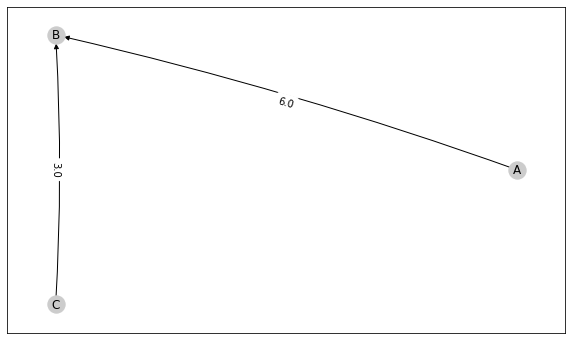

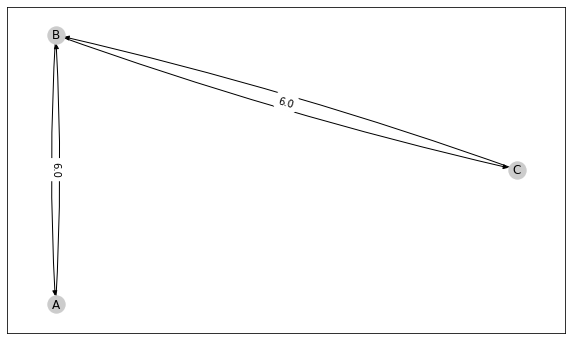

These 1 paths were correctly detected (0 undetected):
['6: ABC']

These 1 paths are spurious:
['3: CBA']


In [57]:
T = [
    list("ABCABCABC"),
]
g, b = evaluate_against(T, ["ABC"] )

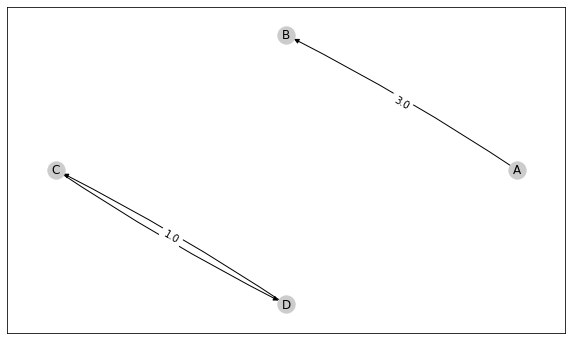

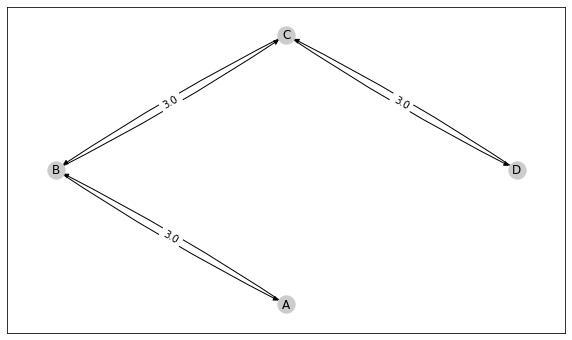

These 1 paths were correctly detected (0 undetected):
['3: ABCD']

These 1 paths are spurious:
['1: DCBA']


In [34]:
T = [
    list("ABCDABCD"),
]
g, b = evaluate_against(T, ["ABCD"] )

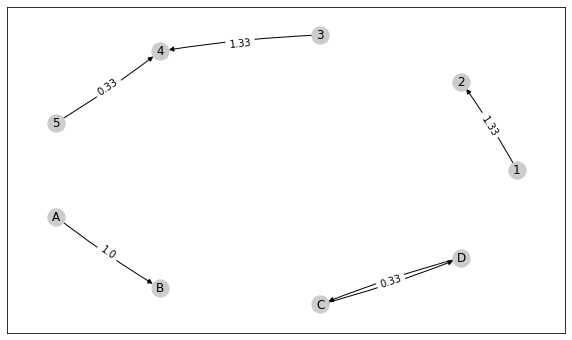

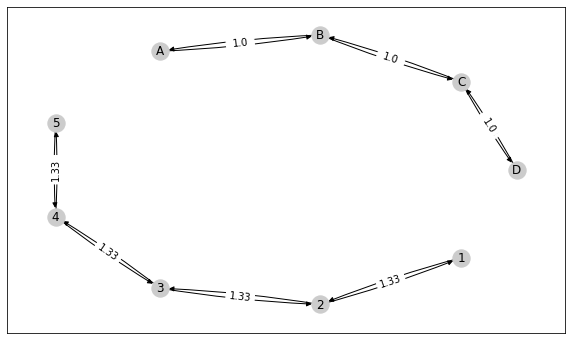

These 2 paths were correctly detected (0 undetected):
['1: ABCD', '1: 12345']

These 2 paths are spurious:
['0: DCBA', '0: 54321']


In [35]:
T = [
    list("ABCDABCD"),
    list("1234512345"),
    list("12345")
]
g, b = evaluate_against(T, ["ABCD", "12345"] )

### Complex Loop Examples

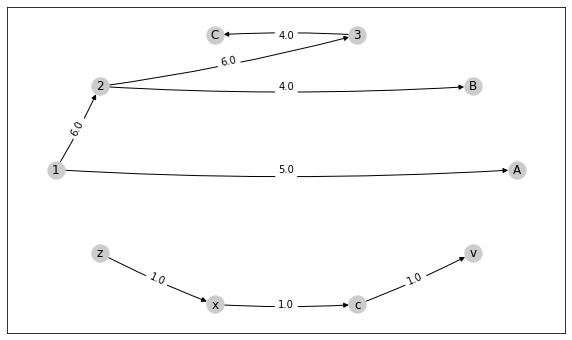

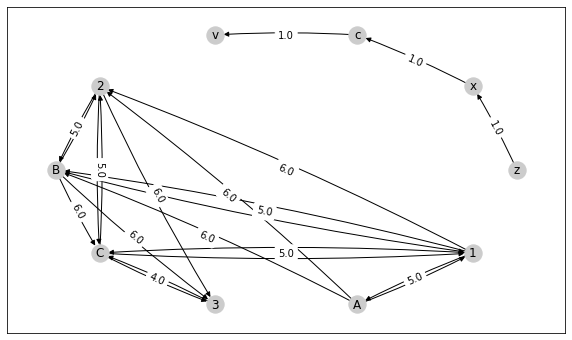

These 3 paths were correctly detected (0 undetected):
['1: zxcv', '6: ABC', '6: 123']

These 14 paths are spurious:
['4: 2B', '4: 2C', '4: 3C', '4: A1', '4: B1', '4: C1', '5: B2', '5: C2', '5: C3', '5: 1A', '5: 1B', '5: 1C', '6: AB3', '6: A23']


In [50]:
# Type 75
T = [
    list("ABC1231A2B3C1ABC23zxcv"),
]
g, b = evaluate_against(T, ("ABC", "123", "zxcv") )

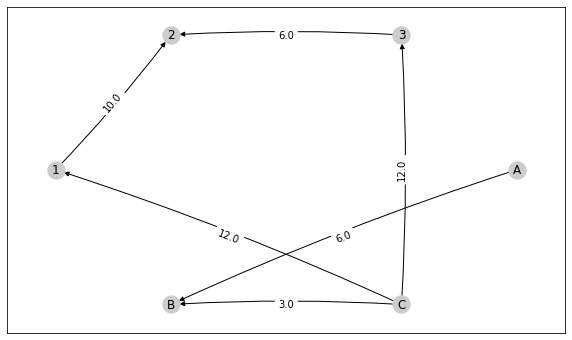

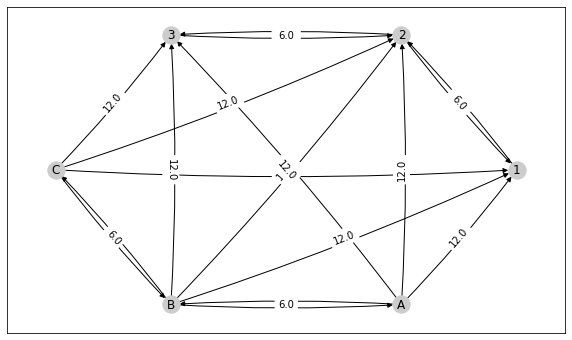

These 2 paths were correctly detected (0 undetected):
['10: 123', '6: ABC']

These 11 paths are spurious:
['3: CBA', '12: A3', '12: A2', '12: A1', '12: B3', '12: B2', '12: B1', '12: C3', '12: C2', '12: C1', '6: 321']


In [51]:
# Type 76
T = [
    list("ABCABCABC123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

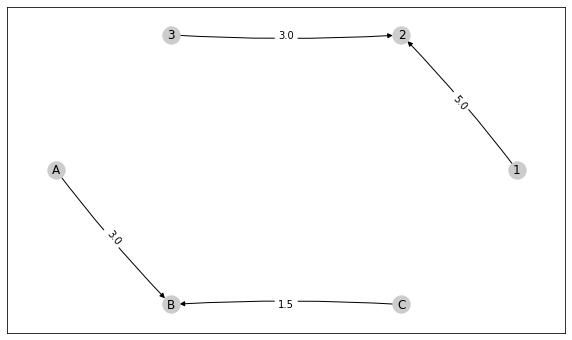

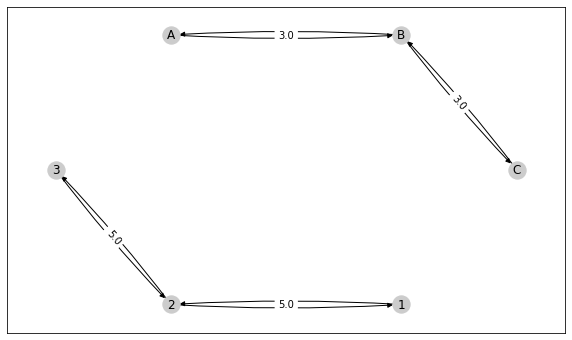

These 2 paths were correctly detected (0 undetected):
['3: ABC', '5: 123']

These 2 paths are spurious:
['1: CBA', '3: 321']


In [38]:
# Type 76-b
T = [
    list("ABCABCABC"),
    list("123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

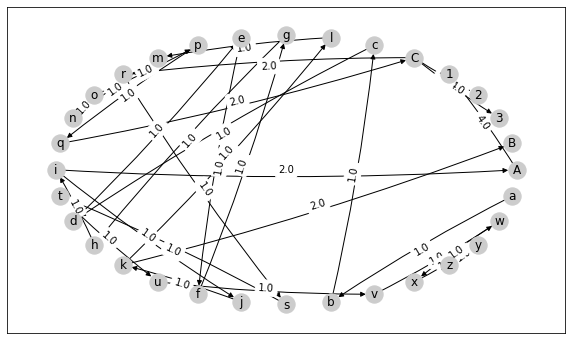

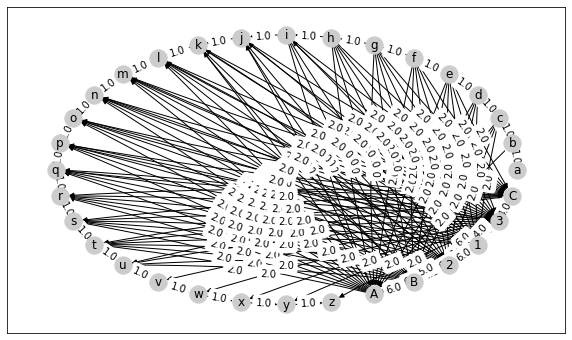

These 3 paths were correctly detected (0 undetected):
['1: abcdefghijklmnopqrstuvwxyz', '6: 123', '6: ABC']

These 126 paths are spurious:
['2: cA', '2: cB', '2: c2', '2: c1', '2: Bl', '2: gB', '2: eB', '2: Bp', '2: Bm', '2: Br', '2: Bo', '2: Bn', '2: Bq', '2: iB', '2: Bt', '2: dB', '2: hB', '2: kB', '2: Bu', '2: fB', '2: jB', '2: Bs', '2: bA', '2: 2l', '2: g2', '2: e2', '2: 2p', '2: 2m', '2: 2r', '2: 2o', '2: 2n', '2: 2q', '2: i2', '2: 2t', '2: d2', '2: h2', '2: k2', '2: 2u', '2: f2', '2: j2', '2: 2s', '2: Am', '2: At', '2: dA', '2: Ak', '2: Al', '2: gA', '2: eA', '2: Ap', '2: Ar', '2: Ao', '2: An', '2: Aq', '2: iA', '2: hA', '2: fA', '2: Aj', '2: As', '2: m3', '2: 3v', '2: 3t', '2: k3', '2: 3u', '2: g3', '2: l3', '2: e3', '2: p3', '2: 3r', '2: 3x', '2: 3q', '2: 3z', '2: n3', '2: o3', '2: i3', '2: h3', '2: 3y', '2: 3w', '2: f3', '2: j3', '2: 3s', '2: d1', '2: 1l', '2: g1', '2: e1', '2: 1p', '2: 1m', '2: 1r', '2: 1o', '2: 1n', '2: 1q', '2: 1i', '2: 1t', '2: 1k', '2: h1', '2: f1', '2: 1

In [39]:
# Type 77
T = [
    list("aAb1B2cd3Cefgh1iAjk2Blmnop3qCrst1AuBC2vwxyz3"),
]
g, b = evaluate_against(T, ("ABC", "123", "abcdefghijklmnopqrstuvwxyz") )

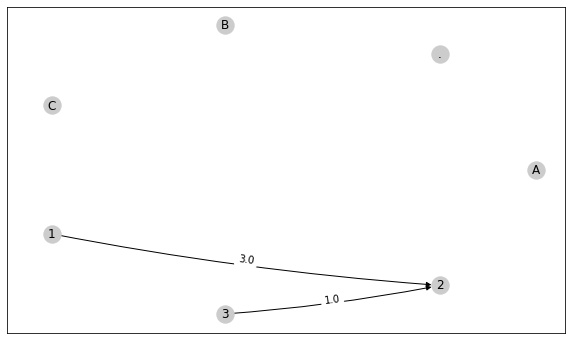

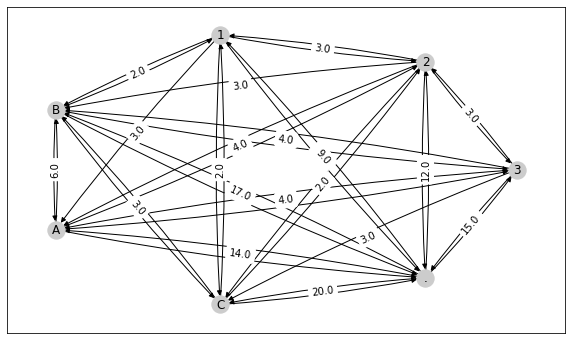

These 2 paths were correctly detected (0 undetected):
['3: 123', '6: ABC']

These 29 paths are spurious:
['1: 321', '2: 3B', '2: B1', '2: 2A', '2: C2', '2: 3A', '2: C1', '3: 3C', '3: CBA', '3: 2B', '3: 1A', '4: B3', '4: 1B', '4: A2', '4: 2C', '4: A3', '4: 1C', '9: .1', '11: 3.', '12: .2', '14: .A', '14: 2.', '15: .3', '17: .B', '17: 1.', '19: C.', '20: .C', '22: B.', '25: A.']


In [40]:
# Type 78
T = [
    list(".1A.B2.C3..ABC...A1..2B..3C.")
]
g, b = evaluate_against(T, ("ABC", "123") )

Claim: all paths (cliques) forming a base are loops. Starting from max(f) -> min(f).

### Examples from previous notebooks

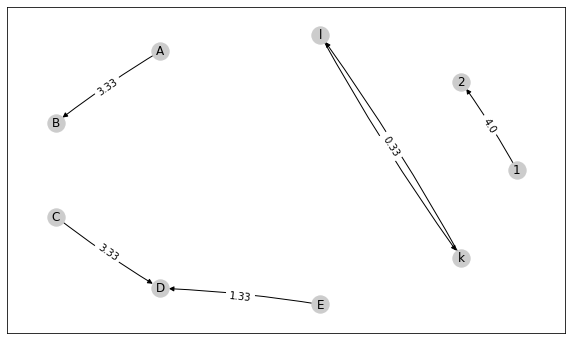

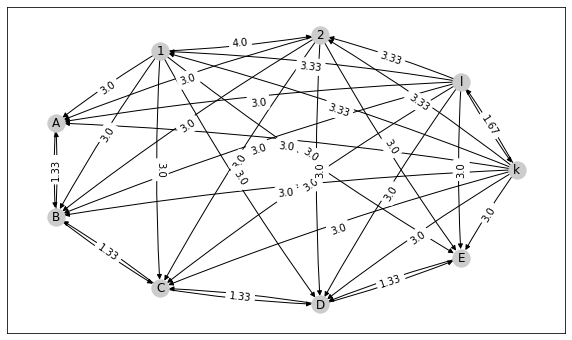

These 3 paths were correctly detected (0 undetected):
['1: lk', '3: ABCDE', '4: 12']

These 26 paths are spurious:
['0: kl', '3: l2', '3: l1', '3: k2', '3: k1', '3: lB', '3: lA', '3: lE', '3: lC', '3: lD', '3: 2B', '3: 2A', '3: 2E', '3: 2C', '3: 2D', '3: kB', '3: kA', '3: kE', '3: kC', '3: kD', '3: 1B', '3: 1A', '3: 1E', '3: 1C', '3: 1D', '1: EDCBA']


In [41]:
# combined_loops: lk 12 ABCDE
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ("ABCDE", "lk", "12") )

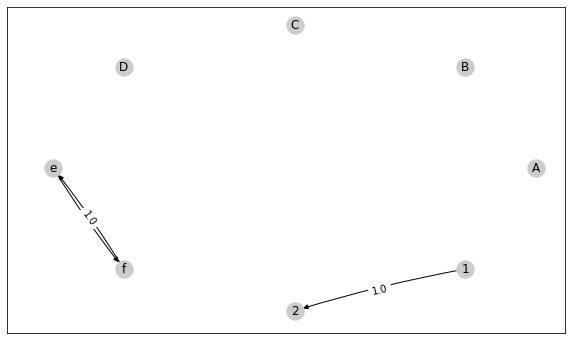

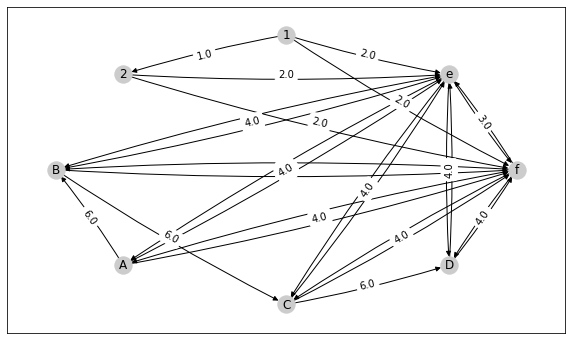

These 3 paths were correctly detected (0 undetected):
['1: 12', '3: ef', '6: ABCD']

These 21 paths are spurious:
['1: fe', '2: eB', '2: 2e', '2: eA', '2: 1e', '2: eC', '2: eD', '2: fB', '2: 2f', '2: fA', '2: 1f', '2: fC', '2: fD', '4: Ae', '4: Be', '4: Ce', '4: De', '4: Af', '4: Bf', '4: Cf', '4: Df']


In [42]:
"""
head_with_loop = 12 ABCD* ef*

12 @ABCD @ef
"""
T = [
    list("12ABCDefABCDABCDef"),
]
g, b = evaluate_against(T, ("ABCD", "12", "ef") )

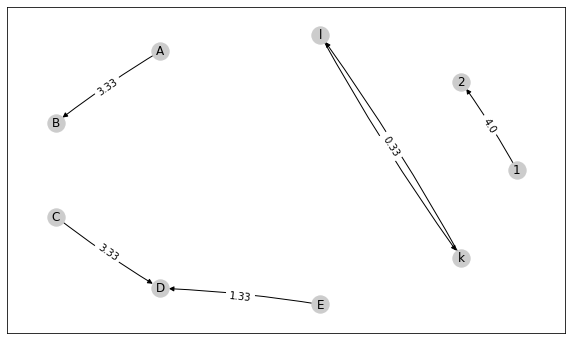

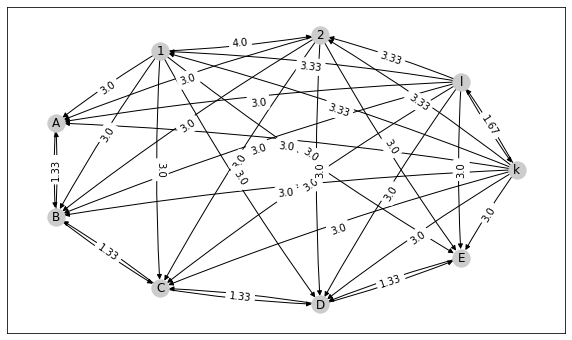

These 3 paths were correctly detected (0 undetected):
['1: lk', '3: ABCDE', '4: 12']

These 26 paths are spurious:
['0: kl', '3: l2', '3: l1', '3: k2', '3: k1', '3: lB', '3: lA', '3: lE', '3: lC', '3: lD', '3: 2B', '3: 2A', '3: 2E', '3: 2C', '3: 2D', '3: kB', '3: kA', '3: kE', '3: kC', '3: kD', '3: 1B', '3: 1A', '3: 1E', '3: 1C', '3: 1D', '1: EDCBA']


In [43]:
"""
  @lk - @12 - @ABCDE
"""
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ["ABCDE", "lk", "12"] )

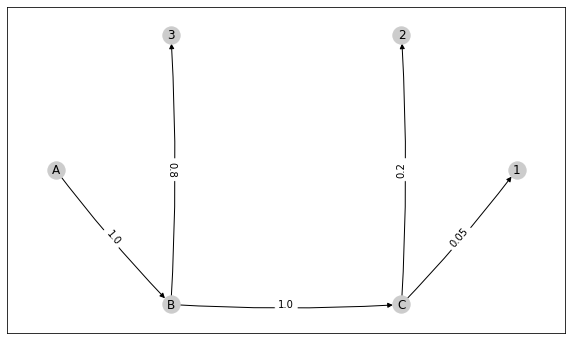

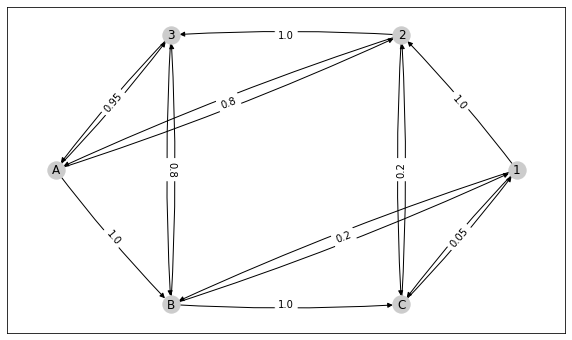

These 2 paths were correctly detected (0 undetected):
['1: 123', '1: ABC']

These 12 paths are spurious:
['0: A2', '0: B3', '0: 1B', '0: 2C', '0: 2A', '0: 3B', '0: B1', '0: C2', '0: A3', '0: 1C', '0: 3A', '0: C1']


In [44]:
"""
   ABC * 123        
"""
T = [ list(a) for a in ['ABC123', 'AB1C23', 'AB12C3', 'AB123C', 'A1BC23', 'A1B2C3', 'A1B23C', 
      'A12BC3', 'A12B3C', 'A123BC', '1ABC23', '1AB2C3', '1AB23C', '1A2BC3', 
      '1A2B3C', '1A23BC', '12ABC3', '12AB3C', '12A3BC', '123ABC'
]]
g, b = evaluate_against(T, ("ABC", "123") )

## Still Failing. Still...

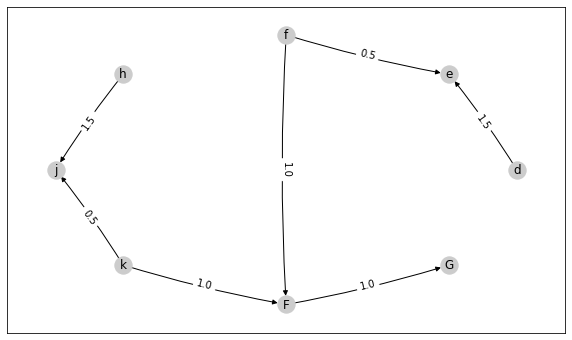

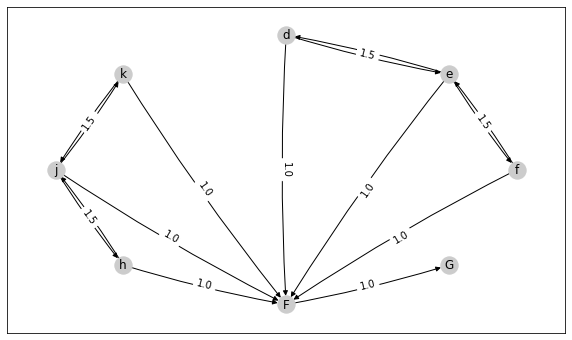



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (1 undetected):
['1: def', '1: hjk']

These 8 paths are spurious:
['0: fed', '0: kjh', '1: eFG', '1: dFG', '1: hFG', '1: kFG', '1: fFG', '1: jFG']


In [45]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("hjk", "def", "FG") )

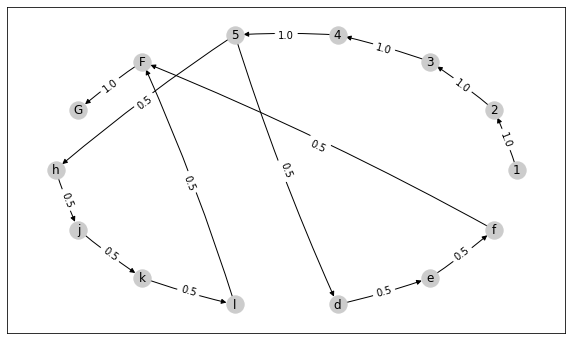

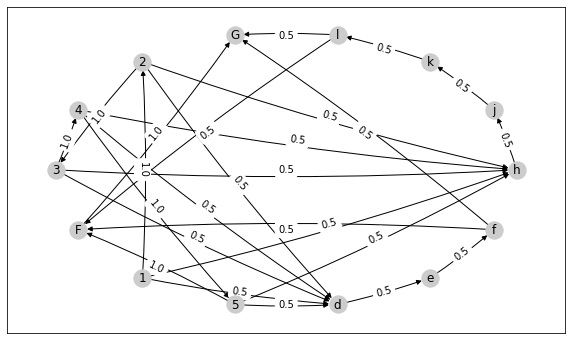



WARNING HERE! OJO AQUI!


These 1 paths were correctly detected (2 undetected):
['1: 12345FG']

These 14 paths are spurious:
['0: hjklG', '0: 2hjkl', '0: 4hjkl', '0: 3hjkl', '0: hjklF', '0: 1hjkl', '0: 5hjkl', '0: defG', '0: 2def', '0: 4def', '0: 3def', '0: defF', '0: 1def', '0: 5def']


In [46]:
"""
          hjk
  12345 <     > FG
          def 
"""
T = [
    list("12345defFG"),
    list("12345hjklFG")
]
g, b = evaluate_against(T, ("12345FG", "hjkl", "def") )

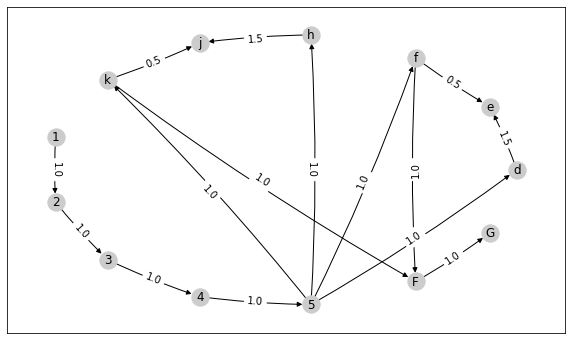

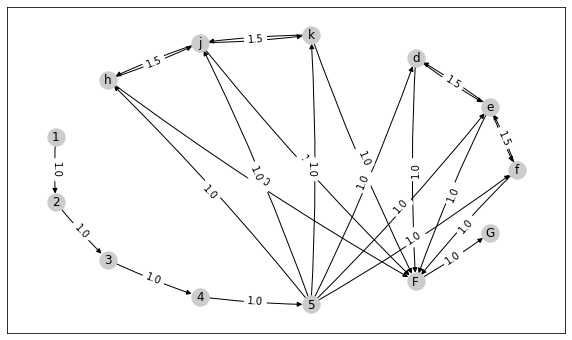



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (2 undetected):
['1: def', '1: hjk']

These 8 paths are spurious:
['0: fed', '0: kjh', '1: 12345eFG', '1: 12345dFG', '1: 12345kFG', '1: 12345hFG', '1: 12345fFG', '1: 12345jFG']


In [47]:
"""
          @hjk
  12345 <      > FG
          @def 
"""
T = [
    list("12345defdefFG"),
    list("12345hjkhjkFG")
]
g, b = evaluate_against(T, ["12345", "hjk", "def", "FG"] )

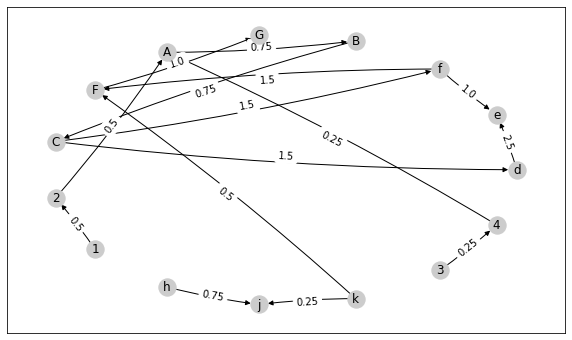

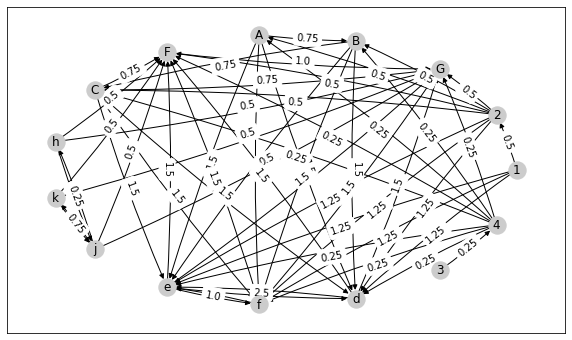



WARNING HERE! OJO AQUI!


These 3 paths were correctly detected (3 undetected):
['1: FG', '0: hjk', '2: def']

These 44 paths are spurious:
['0: 12G', '0: 12B', '0: 12A', '0: 12F', '0: 12C', '0: hF', '0: hG', '0: kF', '0: kG', '0: jF', '0: jG', '1: 2e', '1: 2f', '1: 2d', '1: 1e', '1: 1f', '1: 1d', '1: fed', '0: ABCF', '0: ABCG', '1: Be', '1: eG', '1: Ae', '1: eF', '1: Ce', '1: Bd', '1: dG', '1: Ad', '1: dF', '1: Cd', '1: Bf', '1: fG', '1: Af', '1: fF', '1: Cf', '0: 34G', '0: 34B', '0: 34e', '0: 34C', '0: 34A', '0: 34F', '0: 34d', '0: 34f', '0: kjh']


In [48]:
# loop_inside = @hjk | ( (12 | 34) - ABC - @def - FG) )
"""
                     
  @hjk ----------- 
                  \
   12               > FG
       > ABC - @def 
   34 
        
"""
T = [
    list("12ABCdefdefFG"),
    list("12ABCdefdefdefFG"),
    list("34ABCdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("ABC", "34", "12", "hjk", "def", "FG") )

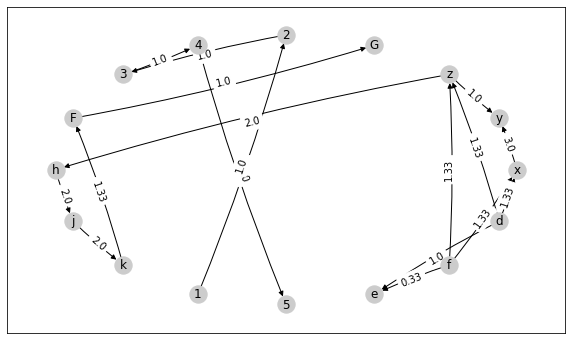

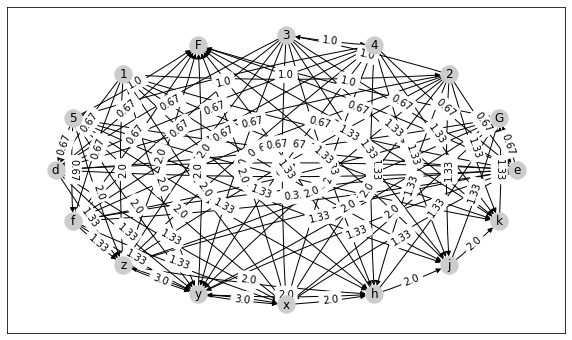



WARNING HERE! OJO AQUI!


These 3 paths were correctly detected (1 undetected):
['1: 12345FG', '1: def', '3: xyz']

These 77 paths are spurious:
['0: eG', '0: 2e', '0: 4e', '0: 3e', '0: eF', '0: 1e', '0: 5e', '0: dG', '0: 2d', '0: 4d', '0: 3d', '0: dF', '0: 1d', '0: 5d', '0: fG', '0: 2f', '0: 4f', '0: 3f', '0: fF', '0: 1f', '0: 5f', '1: zyx', '2: xG', '2: 2x', '2: 4x', '2: 3x', '2: xF', '2: xhjk', '2: 1x', '2: 5x', '2: zG', '2: 2z', '2: 4z', '2: 3z', '2: zF', '2: zhjk', '2: 1z', '2: 5z', '2: yG', '2: 2y', '2: 4y', '2: 3y', '2: yF', '2: yhjk', '2: 1y', '2: 5y', '0: fed', '1: ex', '1: ez', '1: ey', '1: fx', '1: dx', '1: fz', '1: dz', '1: dy', '1: hG', '1: 2h', '1: 4h', '1: 3h', '1: hF', '1: 1h', '1: 5h', '1: fy', '1: kG', '1: 2k', '1: 4k', '1: 3k', '1: kF', '1: 1k', '1: 5k', '1: jG', '1: 2j', '1: 4j', '1: 3j', '1: jF', '1: 1j', '1: 5j']


In [49]:
"""
          @hjk
  12345 <      > FG
          @def 
          @xyz
"""
T = [
    list("12345defdefxyzxyzFG"),
    list("12345xyzxyzhjkhjkFG"),
    list("12345hjkxyzxyzhjkFG"),

]
g, b = evaluate_against(T, ["12345FG", "hjk", "def", "xyz"] )

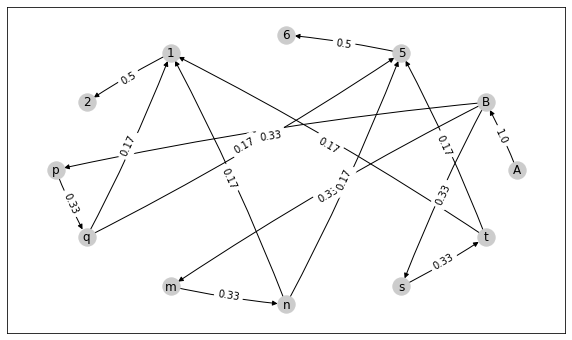

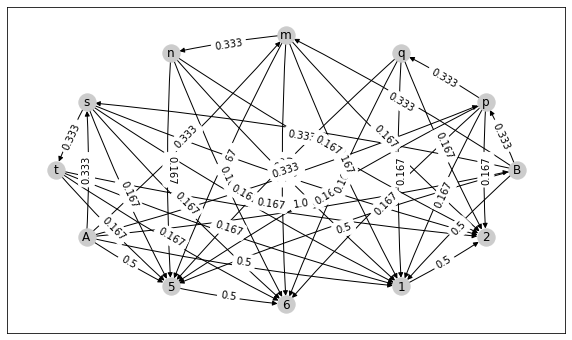



WARNING HERE! OJO AQUI!


These 1 paths were correctly detected (5 undetected):
['1: AB']

These 34 paths are spurious:
['0: Bpq', '0: Bmn', '0: Bst', '0: Apq', '0: Amn', '0: Ast', '0: B56', '0: B12', '0: A56', '0: A12', '0: p2', '0: m2', '0: n2', '0: q2', '0: t2', '0: s2', '0: p6', '0: m6', '0: n6', '0: q6', '0: t6', '0: s6', '0: p1', '0: m1', '0: n1', '0: q1', '0: t1', '0: s1', '0: p5', '0: m5', '0: n5', '0: q5', '0: t5', '0: s5']


In [60]:
tree_trace = [
    list("ABmn12"),
    list("ABmn56"),
    list("ABpq12"),
    list("ABpq56"),
    list("ABst12"),
    list("ABst56"),
]
# inferred_paths = clique_discovery.infer_paths_from_traces( tree_trace )
# untangled_graph( clique_discovery.minimally_connected_graph( inferred_paths ) , with_weigths=False )
g, b = evaluate_against(tree_trace, ["AB", "mn", "12", "pq", "st", "56"] )